<a href="https://colab.research.google.com/github/MMoronto/pytorch_exercises/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [2]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━

##Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [4]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [5]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [6]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,1.325251,-0.212462,0.768819,-2.799400,-0.618019,0.011764
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,-1.130582,-0.567829
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,-0.958050,-1.542342
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,0.356156,0.739868
2023-01-06,-1.055876,0.840536,-0.182525,-1.578654,-0.188925,-2.030661
2023-01-07,-0.383196,1.745819,0.367977,-0.802800,-0.477214,-0.748231
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,1.343809,1.309817


In [7]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [8]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [9]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [10]:
df.head()

,A,B,C,D,E,F
2023-01-01,1.325251,-0.212462,0.768819,-2.799400,-0.618019,0.011764
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,-1.130582,-0.567829
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,-0.958050,-1.542342
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,0.356156,0.739868


In [11]:
df.tail()

,A,B,C,D,E,F
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,-0.958050,-1.542342
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,0.356156,0.739868
2023-01-06,-1.055876,0.840536,-0.182525,-1.578654,-0.188925,-2.030661
2023-01-07,-0.383196,1.745819,0.367977,-0.802800,-0.477214,-0.748231
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,1.343809,1.309817


In [12]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [13]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [14]:
df.to_numpy()

array([[ 1.3252506 , -0.21246188,  0.76881924, -2.79940016, -0.61801908,
         0.01176376],
       [-1.79082776,  0.28052528,  0.35484171, -0.9307354 , -1.13058243,
        -0.56782904],
       [-0.66649626,  0.42858006,  0.11194554,  0.04057331,  0.75267993,
         0.30844475],
       [-0.79939402,  0.02787348,  0.47830745, -0.05837051, -0.95805023,
        -1.54234171],
       [-1.64986845, -0.18007337, -0.2101707 ,  0.76922896,  0.35615589,
         0.73986798],
       [-1.05587585,  0.8405358 , -0.18252504, -1.57865428, -0.18892516,
        -2.03066146],
       [-0.38319619,  1.74581893,  0.36797716, -0.80280032, -0.47721397,
        -0.74823057],
       [ 0.39594563, -1.91585384,  0.87526383, -0.8775218 ,  1.34380936,
         1.30981662]])

In [15]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [16]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.578058,0.126868,0.320557,-0.779710,-0.115018,-0.314896
std,1.036060,1.044498,0.399147,1.091707,0.864772,1.130721
min,-1.790828,-1.915854,-0.210171,-2.799400,-1.130582,-2.030661
25%,-1.204374,-0.188170,0.038328,-1.092715,-0.703027,-0.946758
50%,-0.732945,0.154199,0.361409,-0.840161,-0.333070,-0.278033
75%,-0.188411,0.531569,0.550935,-0.033635,0.455287,0.416301
max,1.325251,1.745819,0.875264,0.769229,1.343809,1.309817


In [17]:
df

,A,B,C,D,E,F
2023-01-01,1.325251,-0.212462,0.768819,-2.799400,-0.618019,0.011764
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,-1.130582,-0.567829
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,-0.958050,-1.542342
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,0.356156,0.739868
2023-01-06,-1.055876,0.840536,-0.182525,-1.578654,-0.188925,-2.030661
2023-01-07,-0.383196,1.745819,0.367977,-0.802800,-0.477214,-0.748231
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,1.343809,1.309817


In [18]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,1.325251,-1.790828,-0.666496,-0.799394,-1.649868,-1.055876,-0.383196,0.395946
B,-0.212462,0.280525,0.428580,0.027873,-0.180073,0.840536,1.745819,-1.915854
C,0.768819,0.354842,0.111946,0.478307,-0.210171,-0.182525,0.367977,0.875264
D,-2.799400,-0.930735,0.040573,-0.058371,0.769229,-1.578654,-0.802800,-0.877522
E,-0.618019,-1.130582,0.752680,-0.958050,0.356156,-0.188925,-0.477214,1.343809
F,0.011764,-0.567829,0.308445,-1.542342,0.739868,-2.030661,-0.748231,1.309817


In [19]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,0.011764,-0.618019,-2.799400,0.768819,-0.212462,1.325251
2023-01-02,-0.567829,-1.130582,-0.930735,0.354842,0.280525,-1.790828
2023-01-03,0.308445,0.752680,0.040573,0.111946,0.428580,-0.666496
2023-01-04,-1.542342,-0.958050,-0.058371,0.478307,0.027873,-0.799394
2023-01-05,0.739868,0.356156,0.769229,-0.210171,-0.180073,-1.649868
2023-01-06,-2.030661,-0.188925,-1.578654,-0.182525,0.840536,-1.055876
2023-01-07,-0.748231,-0.477214,-0.802800,0.367977,1.745819,-0.383196
2023-01-08,1.309817,1.343809,-0.877522,0.875264,-1.915854,0.395946


In [20]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,1.343809,1.309817
2023-01-01,1.325251,-0.212462,0.768819,-2.799400,-0.618019,0.011764
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,0.356156,0.739868
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,-0.958050,-1.542342
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,-1.130582,-0.567829
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445
2023-01-06,-1.055876,0.840536,-0.182525,-1.578654,-0.188925,-2.030661
2023-01-07,-0.383196,1.745819,0.367977,-0.802800,-0.477214,-0.748231


In [21]:
df

,A,B,C,D,E,F
2023-01-01,1.325251,-0.212462,0.768819,-2.799400,-0.618019,0.011764
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,-1.130582,-0.567829
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,-0.958050,-1.542342
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,0.356156,0.739868
2023-01-06,-1.055876,0.840536,-0.182525,-1.578654,-0.188925,-2.030661
2023-01-07,-0.383196,1.745819,0.367977,-0.802800,-0.477214,-0.748231
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,1.343809,1.309817


##Getting

In [22]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01    1.325251
2023-01-02   -1.790828
2023-01-03   -0.666496
2023-01-04   -0.799394
2023-01-05   -1.649868
2023-01-06   -1.055876
2023-01-07   -0.383196
2023-01-08    0.395946
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [23]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,1.325251,-0.212462,0.768819,-2.799400,-0.618019,0.011764
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,-1.130582,-0.567829
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445


In [24]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,-1.130582,-0.567829
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,-0.958050,-1.542342


In [25]:
df

,A,B,C,D,E,F
2023-01-01,1.325251,-0.212462,0.768819,-2.799400,-0.618019,0.011764
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,-1.130582,-0.567829
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,-0.958050,-1.542342
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,0.356156,0.739868
2023-01-06,-1.055876,0.840536,-0.182525,-1.578654,-0.188925,-2.030661
2023-01-07,-0.383196,1.745819,0.367977,-0.802800,-0.477214,-0.748231
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,1.343809,1.309817


##Selection by label

In [26]:
df.loc[dates[1]]

A   -1.790828
B    0.280525
C    0.354842
D   -0.930735
E   -1.130582
F   -0.567829
Name: 2023-01-02 00:00:00, dtype: float64

In [27]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,1.325251,-2.799400
2023-01-02,-1.790828,-0.930735
2023-01-03,-0.666496,0.040573
2023-01-04,-0.799394,-0.058371
2023-01-05,-1.649868,0.769229
2023-01-06,-1.055876,-1.578654
2023-01-07,-0.383196,-0.802800
2023-01-08,0.395946,-0.877522


In [28]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,-0.799394,-0.058371
2023-01-05,-1.649868,0.769229
2023-01-06,-1.055876,-1.578654


In [29]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A   -0.799394
D   -0.058371
Name: 2023-01-04 00:00:00, dtype: float64

In [30]:
# For getting a scalar value
df.loc[dates[1], "D"]

-0.9307353972926822

In [31]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

-0.9307353972926822

##Selection by position

In [32]:
df.iloc[3]

A   -0.799394
B    0.027873
C    0.478307
D   -0.058371
E   -0.958050
F   -1.542342
Name: 2023-01-04 00:00:00, dtype: float64

In [33]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,-0.799394,0.027873
2023-01-05,-1.649868,-0.180073


In [34]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,-1.790828,0.354842
2023-01-03,-0.666496,0.111946
2023-01-05,-1.649868,-0.210171


In [35]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,-1.130582,-0.567829
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445


In [36]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,-0.212462,0.768819
2023-01-02,0.280525,0.354842
2023-01-03,0.428580,0.111946
2023-01-04,0.027873,0.478307
2023-01-05,-0.180073,-0.210171
2023-01-06,0.840536,-0.182525
2023-01-07,1.745819,0.367977
2023-01-08,-1.915854,0.875264


In [37]:
# For getting values explicitly
df.iloc[1, 1]

0.280525284214616

In [38]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

0.280525284214616

## Boolean indexing
Using a single column's values to select data:

In [39]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-01,1.325251,-0.212462,0.768819,-2.799400,-0.618019,0.011764
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,1.343809,1.309817


In [40]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,1.325251,NaN,0.768819,NaN,NaN,0.011764
2023-01-02,NaN,0.280525,0.354842,NaN,NaN,NaN
2023-01-03,NaN,0.428580,0.111946,0.040573,0.752680,0.308445
2023-01-04,NaN,0.027873,0.478307,NaN,NaN,NaN
2023-01-05,NaN,NaN,NaN,0.769229,0.356156,0.739868
2023-01-06,NaN,0.840536,NaN,NaN,NaN,NaN
2023-01-07,NaN,1.745819,0.367977,NaN,NaN,NaN
2023-01-08,0.395946,NaN,0.875264,NaN,1.343809,1.309817


In [41]:
df

,A,B,C,D,E,F
2023-01-01,1.325251,-0.212462,0.768819,-2.799400,-0.618019,0.011764
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,-1.130582,-0.567829
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,-0.958050,-1.542342
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,0.356156,0.739868
2023-01-06,-1.055876,0.840536,-0.182525,-1.578654,-0.188925,-2.030661
2023-01-07,-0.383196,1.745819,0.367977,-0.802800,-0.477214,-0.748231
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,1.343809,1.309817


In [42]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,1.325251,-0.212462,0.768819,-2.799400,-0.618019,0.011764,one
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,-1.130582,-0.567829,one
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445,two
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,-0.958050,-1.542342,three
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,0.356156,0.739868,four
2023-01-06,-1.055876,0.840536,-0.182525,-1.578654,-0.188925,-2.030661,three
2023-01-07,-0.383196,1.745819,0.367977,-0.802800,-0.477214,-0.748231,five
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,1.343809,1.309817,four


In [43]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445,two
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,0.356156,0.739868,four
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,1.343809,1.309817,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [44]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [45]:
df["G"] = s1

In [46]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [47]:
# Setting values by position:
df.iat[0, 1] = 0

In [48]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,0.768819,-2.799400,-0.618019,0.011764,NaN
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,-1.130582,-0.567829,1.0
2023-01-03,-0.666496,0.428580,0.111946,0.040573,0.752680,0.308445,2.0
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,-0.958050,-1.542342,3.0
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,0.356156,0.739868,4.0
2023-01-06,-1.055876,0.840536,-0.182525,-1.578654,-0.188925,-2.030661,5.0
2023-01-07,-0.383196,1.745819,0.367977,-0.802800,-0.477214,-0.748231,6.0
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,1.343809,1.309817,NaN


In [49]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [50]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,0.768819,-2.799400,5,0.011764,NaN
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,5,-0.567829,1.0
2023-01-03,-0.666496,0.428580,0.111946,0.040573,5,0.308445,2.0
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,5,-1.542342,3.0
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,5,0.739868,4.0
2023-01-06,-1.055876,0.840536,-0.182525,-1.578654,5,-2.030661,5.0
2023-01-07,-0.383196,1.745819,0.367977,-0.802800,5,-0.748231,6.0
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,5,1.309817,NaN


In [51]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.768819,-2.799400,-5,-0.011764,NaN
2023-01-02,-1.790828,-0.280525,-0.354842,-0.930735,-5,-0.567829,-1.0
2023-01-03,-0.666496,-0.428580,-0.111946,-0.040573,-5,-0.308445,-2.0
2023-01-04,-0.799394,-0.027873,-0.478307,-0.058371,-5,-1.542342,-3.0
2023-01-05,-1.649868,-0.180073,-0.210171,-0.769229,-5,-0.739868,-4.0
2023-01-06,-1.055876,-0.840536,-0.182525,-1.578654,-5,-2.030661,-5.0
2023-01-07,-0.383196,-1.745819,-0.367977,-0.802800,-5,-0.748231,-6.0
2023-01-08,-0.395946,-1.915854,-0.875264,-0.877522,-5,-1.309817,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [52]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,0.768819,-2.799400,5,0.011764,1.0,1.0
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,5,-0.567829,1.0,1.0
2023-01-03,-0.666496,0.428580,0.111946,0.040573,5,0.308445,2.0,2.0
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,5,-1.542342,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [53]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,0.768819,-2.799400,5,0.011764,1.0,1.0
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,5,-0.567829,1.0,1.0
2023-01-03,-0.666496,0.428580,0.111946,0.040573,5,0.308445,2.0,2.0
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,5,-1.542342,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [54]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,0.768819,-2.799400,5,0.011764,1.0,1.0
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,5,-0.567829,1.0,1.0
2023-01-03,-0.666496,0.428580,0.111946,0.040573,5,0.308445,2.0,2.0
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,5,-1.542342,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [55]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [56]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,0.768819,-2.799400,5,0.011764,NaN
2023-01-02,-1.790828,0.280525,0.354842,-0.930735,5,-0.567829,1.0
2023-01-03,-0.666496,0.428580,0.111946,0.040573,5,0.308445,2.0
2023-01-04,-0.799394,0.027873,0.478307,-0.058371,5,-1.542342,3.0
2023-01-05,-1.649868,-0.180073,-0.210171,0.769229,5,0.739868,4.0
2023-01-06,-1.055876,0.840536,-0.182525,-1.578654,5,-2.030661,5.0
2023-01-07,-0.383196,1.745819,0.367977,-0.802800,5,-0.748231,6.0
2023-01-08,0.395946,-1.915854,0.875264,-0.877522,5,1.309817,NaN


In [57]:
df.mean()

A   -0.743714
B    0.153426
C    0.320557
D   -0.779710
E    5.000000
F   -0.314896
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [58]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [59]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-1.666496,-0.571420,-0.888054,-0.959427,4.0,-0.691555,1.0
2023-01-04,-3.799394,-2.972127,-2.521693,-3.058371,2.0,-4.542342,0.0
2023-01-05,-5.649868,-4.180073,-4.210171,-3.230771,1.0,-3.260132,0.0
2023-01-06,-6.055876,-4.159464,-5.182525,-6.578654,0.0,-7.030661,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-5.604054,-7.915854,-5.124736,-6.877522,-1.0,-4.690183,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [60]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,0.768819,-2.799400,5,0.011764,NaN
2023-01-02,-1.790828,0.280525,1.123661,-3.730136,10,-0.556065,1.0
2023-01-03,-2.457324,0.709105,1.235606,-3.689562,15,-0.247621,3.0
2023-01-04,-3.256718,0.736979,1.713914,-3.747933,20,-1.789962,6.0
2023-01-05,-4.906586,0.556905,1.503743,-2.978704,25,-1.050094,10.0
2023-01-06,-5.962462,1.397441,1.321218,-4.557358,30,-3.080756,15.0
2023-01-07,-6.345659,3.143260,1.689195,-5.360158,35,-3.828986,21.0
2023-01-08,-5.949713,1.227406,2.564459,-6.237680,40,-2.519170,NaN


In [61]:
df.apply(lambda x: x.max() - x.min())

A    2.186773
B    3.661673
C    1.085435
D    3.568629
E    0.000000
F    3.340478
G    5.000000
dtype: float64

##Histogramming

In [62]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    1
1    0
2    6
3    1
4    3
5    1
6    4
7    6
8    1
9    5
dtype: int64

In [63]:
s.value_counts()

1    4
6    2
0    1
3    1
4    1
5    1
dtype: int64

##String Methods


In [64]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [65]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,0.110093,-0.675905,1.251685,3.163375
1,-0.787926,1.466054,-1.077870,0.764383
2,-0.535712,0.804251,-0.799056,-2.266956
3,0.551506,0.048854,0.700234,-0.277745
4,-1.182974,-0.553801,-0.098129,1.993063
5,-0.970210,1.641363,0.089728,0.105676
6,-0.736825,1.258327,-1.530762,-0.341369
7,-1.343917,-0.528832,0.399519,-1.772957
8,-0.387513,-0.247950,-1.169752,-0.906639
9,1.312816,0.966197,-2.278354,-0.504898


In [66]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,0.110093,-0.675905,1.251685,3.163375
1,-0.787926,1.466054,-1.077870,0.764383
2,-0.535712,0.804251,-0.799056,-2.266956
3,0.551506,0.048854,0.700234,-0.277745
4,-1.182974,-0.553801,-0.098129,1.993063
5,-0.970210,1.641363,0.089728,0.105676
6,-0.736825,1.258327,-1.530762,-0.341369
7,-1.343917,-0.528832,0.399519,-1.772957
8,-0.387513,-0.247950,-1.169752,-0.906639
9,1.312816,0.966197,-2.278354,-0.504898


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [67]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [68]:
right

,key,rval
0,foo,4
1,foo,5


In [69]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [70]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [71]:
right

,key,rval
0,foo,4
1,bar,5


In [72]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [73]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,0.418992,0.051202
1,bar,one,-1.043761,1.489968
2,foo,two,-2.324475,-1.225977
3,bar,three,0.661688,0.796562
4,foo,two,-0.672286,-0.296472
5,bar,two,0.129275,0.389951
6,foo,one,1.574561,0.052244
7,foo,three,1.345770,-1.234190


Grouping and then applying the `sum()` function to the resulting groups:

In [74]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,-0.252797,2.676480
foo,0.342561,-2.653193


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [75]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one   -1.043761  1.489968
    three  0.661688  0.796562
    two    0.129275  0.389951
foo one    1.993553  0.103446
    three  1.345770 -1.234190
    two   -2.996762 -1.522449

##Reshaping
**Stack**

In [76]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one    -0.049207  1.729805
      two     0.287938 -1.600297
baz   one     0.650705  1.208344
      two     0.818155  2.103960

The `stack()` method "compresses" a level in the DataFrame's columns:

In [77]:
stacked = df2.stack()
stacked

first  second   
bar    one     A   -0.049207
               B    1.729805
       two     A    0.287938
               B   -1.600297
baz    one     A    0.650705
               B    1.208344
       two     A    0.818155
               B    2.103960
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [78]:
stacked.unstack()

A         B
first second                    
bar   one    -0.049207  1.729805
      two     0.287938 -1.600297
baz   one     0.650705  1.208344
      two     0.818155  2.103960

In [79]:
stacked.unstack(1)

second        one       two
first                      
bar   A -0.049207  0.287938
      B  1.729805 -1.600297
baz   A  0.650705  0.818155
      B  1.208344  2.103960

In [80]:
stacked.unstack(0)

first          bar       baz
second                      
one    A -0.049207  0.650705
       B  1.729805  1.208344
two    A  0.287938  0.818155
       B -1.600297  2.103960

##Pivot tables

In [81]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,-0.320965,-0.019891
1,one,B,foo,-0.700450,-1.591197
2,two,C,foo,-1.380307,0.309640
3,three,A,bar,-0.592470,-0.937578
4,one,B,bar,0.894094,-1.019262
5,one,C,bar,-0.593283,0.958386
6,two,A,foo,0.978292,0.125145
7,three,B,foo,-1.374992,-1.850710
8,one,C,foo,0.914864,1.145206
9,one,A,bar,-0.134344,-1.769865


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [82]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A -0.134344 -0.320965
      B  0.894094 -0.700450
      C -0.593283  0.914864
three A -0.592470       NaN
      B       NaN -1.374992
      C  0.532897       NaN
two   A       NaN  0.978292
      B -1.051618       NaN
      C       NaN -1.380307

##Time series

In [83]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    24036
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [84]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06   -0.155543
2012-03-07   -0.455930
2012-03-08    0.347563
2012-03-09   -0.610412
2012-03-10    0.127335
Freq: D, dtype: float64

In [85]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00   -0.155543
2012-03-07 00:00:00+00:00   -0.455930
2012-03-08 00:00:00+00:00    0.347563
2012-03-09 00:00:00+00:00   -0.610412
2012-03-10 00:00:00+00:00    0.127335
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [86]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00   -0.155543
2012-03-06 19:00:00-05:00   -0.455930
2012-03-07 19:00:00-05:00    0.347563
2012-03-08 19:00:00-05:00   -0.610412
2012-03-09 19:00:00-05:00    0.127335
Freq: D, dtype: float64

Converting between time span representations:

In [87]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31   -1.785606
2012-02-29   -0.869462
2012-03-31    0.595826
2012-04-30    1.509650
2012-05-31    1.497331
Freq: M, dtype: float64

In [88]:
ps = ts.to_period()

ps 

2012-01   -1.785606
2012-02   -0.869462
2012-03    0.595826
2012-04    1.509650
2012-05    1.497331
Freq: M, dtype: float64

In [89]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01   -1.785606
2012-02-01   -0.869462
2012-03-01    0.595826
2012-04-01    1.509650
2012-05-01    1.497331
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [90]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00    1.172872
1990-06-01 09:00   -0.599280
1990-09-01 09:00   -1.424754
1990-12-01 09:00   -0.453559
1991-03-01 09:00    0.432673
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [91]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [92]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [93]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [94]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [95]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [96]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [97]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

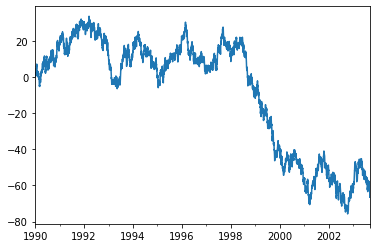

In [98]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [99]:
plt.show();

<Figure size 432x288 with 0 Axes>

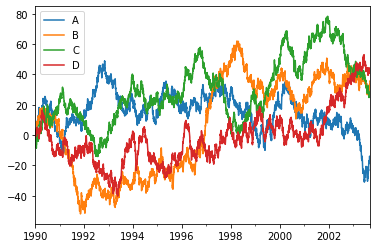

In [100]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [101]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [102]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,0.205740,0.437565,2.564497,0.153656
1,1990-01-02,1.587861,0.283823,2.867869,-0.770739
2,1990-01-03,0.843530,0.120723,3.245115,0.294255
3,1990-01-04,0.638906,0.115651,2.745427,0.187355
4,1990-01-05,-0.383951,-0.283030,2.913314,-0.099272
...,...,...,...,...,...
4995,2003-09-05,-15.027068,32.804268,27.400344,41.582121
4996,2003-09-06,-14.616144,34.799072,25.549906,42.112493
4997,2003-09-07,-15.312155,34.946879,26.467727,41.441659
4998,2003-09-08,-15.496903,35.771519,26.728434,40.859912


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [103]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [104]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,0.205740,0.437565,2.564497,0.153656
1990-01-02,1.587861,0.283823,2.867869,-0.770739
1990-01-03,0.843530,0.120723,3.245115,0.294255
1990-01-04,0.638906,0.115651,2.745427,0.187355
1990-01-05,-0.383951,-0.283030,2.913314,-0.099272
...,...,...,...,...
2003-09-05,-15.027068,32.804268,27.400344,41.582121
2003-09-06,-14.616144,34.799072,25.549906,42.112493
2003-09-07,-15.312155,34.946879,26.467727,41.441659
2003-09-08,-15.496903,35.771519,26.728434,40.859912


##Excel

Reading & writing to Excel.

Writing to an excel file using `DataFrame.to_excel()`:

In [105]:
df.to_excel("foo.xlsx", sheet_name="Sheet1")

In [106]:
pd.read_excel("foo.xlsx", "Sheet1", index_col=None, na_values=["NA"])

,Unnamed: 0,A,B,C,D
0,1990-01-01,0.205740,0.437565,2.564497,0.153656
1,1990-01-02,1.587861,0.283823,2.867869,-0.770739
2,1990-01-03,0.843530,0.120723,3.245115,0.294255
3,1990-01-04,0.638906,0.115651,2.745427,0.187355
4,1990-01-05,-0.383951,-0.283030,2.913314,-0.099272
...,...,...,...,...,...
4995,2003-09-05,-15.027068,32.804268,27.400344,41.582121
4996,2003-09-06,-14.616144,34.799072,25.549906,42.112493
4997,2003-09-07,-15.312155,34.946879,26.467727,41.441659
4998,2003-09-08,-15.496903,35.771519,26.728434,40.859912


##Series
a one-dimensional labeled array capable of holding any data type(integers, strings, ..etc)

`s = pd.Series(data, index=index)`


###**From ndarray**

If `data` is an ndarray, index must be the same length as data. If no index is passed, one will be created having values `[0, ..., len(data) - 1]`.

In [107]:
# From ndarray
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
s

a   -2.673680
b    1.048316
c   -0.862001
d   -0.149724
e    0.182458
dtype: float64

In [108]:
s.index

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [109]:
pd.Series(np.random.randn(5))

0   -0.372944
1   -0.549958
2   -0.221801
3    2.659974
4   -0.254218
dtype: float64

**From dict**
`Series` can be instantiated from dicts:

In [110]:
d = {"d":1, "a": 0, "c": 2}
pd.Series(d)

d    1
a    0
c    2
dtype: int64

In [111]:
# If an index is passed, the values in data corresponding to the labels in the index will be returned:

d = {"a": 0.0, "b": 1.0, "c": 2.0}

pd.Series(d)

a    0.0
b    1.0
c    2.0
dtype: float64

In [112]:
pd.Series(d, index=["b", "c", "d", "a"])

b    1.0
c    2.0
d    NaN
a    0.0
dtype: float64

**From scalar value**

If `data` is a scalar value, an index must be provided. The value will be repeated to match the length of the index.

In [118]:
pd.Series( '5a', index=["a", "b", "c", "d", "e"])

a    5a
b    5a
c    5a
d    5a
e    5a
dtype: object

In [125]:
s[s>s.median()]

b    1.048316
e    0.182458
dtype: float64